In [5]:
print(__doc__)

# Author: Darryl Delacruz <darryl@delacruz.net>
#
# License: BSD 3 clause

Automatically created module for IPython interactive environment


# Python Machine Learning Project
## Choice Selection
### Kaggle Bike Sharing Dataset
Desired to explore a real world problem. I chose the financial problem over the environmental one thinking I might be able to apply my newly gained understanding to some future family business need.
### Regression Model
Since the Kaggle Bicycle challenge is to output the number of bicycles to be rented, which is a "real" number, and, since regression models predict real numbers, I chose sklearn GradientBoostingRegressor  regression model. I also chose this model since it is well documented, the dataset is small (i.e. less than 100,000 data points) and therefore easier to manage in terms of visualization and cpu compute cycles, and I'm guessing the relatively small feature count is appropriate for a "weak-learner" model.
## Effort Expended (1 day = 8 hours)
- Educate and research GradientBoostingRegressor, sklearn and tools (python, pandas, numpy, matplotlib, seaborn): projected 2 days, actual 2 days
- Coding to explore Kaggle Bicycle Share dataset: projected 1 day, actual 1 day
- Implement Python ML solution: projected 1 day, actual 1 day

## References
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor

https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/
## Future
Try training other model types like "Long Short Term Memory" and "Reinforcement Learning", since I suspect there is a strong correlation in the sequence of samples (i.e. hour to hour). 

## Load and Clean the Kaggle Bicycle Dataset

season        category
holiday       category
workingday    category
weather       category
atemp          float64
humidity         int64
windspeed      float64
year          category
day           category
hour          category
dow           category
dtype: object


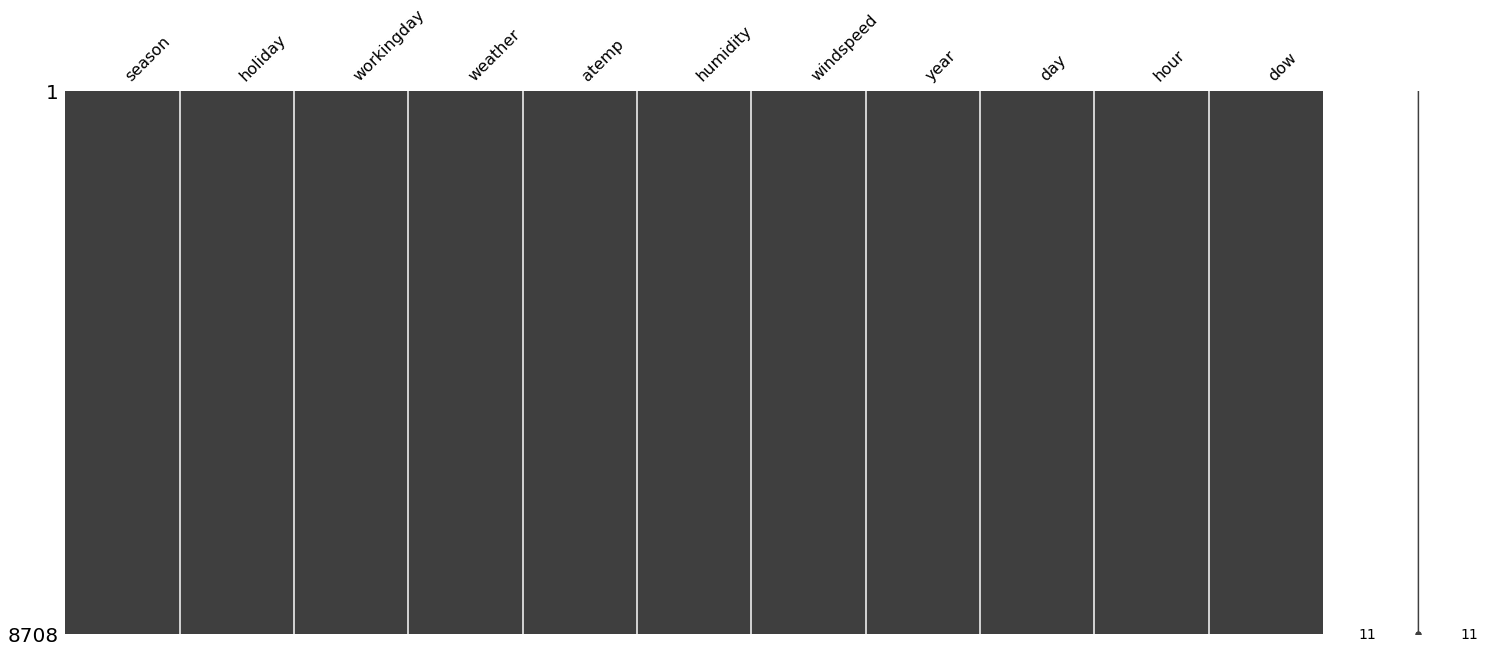

In [6]:
import pandas as pd
import missingno as msno
from sklearn.model_selection import train_test_split

# Read Kaggle final test dataset.
bike_final_test=pd.read_csv('./bike-sharing-demand-final-test.csv')

# Read the Kaggle input datasets.
bike=pd.read_csv('./bike-sharing-demand.csv')

# Create Bike Input dataset and remove temp feature since we discovered (see below)
# a 95% correlation with the atemp (i.e. feels-like temperature) feature.
bike_input=bike.drop(columns=['temp'])
bike_final_test=bike_final_test.drop(columns=['temp'])

# Convert datetime string to datetime object for both input and final test data.
bike_input['datetime']=pd.to_datetime(bike_input['datetime'])
bike_final_test['datetime']=pd.to_datetime(bike_final_test['datetime'])

# From datetime extract and make the following features for both
#   input and final test data (note: month was 97% correlated
#   with season, so month was left out of the derivation): 
#   - year (2011, 2012)
#   - day - day of the month (1-31)
#   - hour (0-23)
#   - dow - day-of-the-week (0-Mon, 1-Tue, 2-Wed, 3-Thu, 4-Fri, 5-Sat, 6-Sun)
#       May be important to help unbias bike renters who work on weekends.
bike_input['year'] = bike_input['datetime'].dt.year
bike_input['day'] = bike_input['datetime'].dt.day
bike_input['hour'] = bike_input['datetime'].dt.hour
bike_input['dow'] = bike_input['datetime'].dt.dayofweek

bike_final_test['year'] = bike_final_test['datetime'].dt.year
bike_final_test['day'] = bike_final_test['datetime'].dt.day
bike_final_test['hour'] = bike_final_test['datetime'].dt.hour
bike_final_test['dow'] = bike_final_test['datetime'].dt.dayofweek

# Remove "casual" and "registered" features (i.e. columns) since they
#   are NOT in the Kaggle final test dataset. Also we are trying to 
#   only use weather and time to make predictions.
# Remove datetime from both input and final test data since they are 
#   already completely correlated with the other time related the
#   fields (year, month, day-of-month, hour, day-of-week).
bike_input=bike_input.drop(columns=['casual','registered', 'datetime'])
bike_final_test=bike_final_test.drop(columns=['datetime'])

# Coerce data into categories.
categoryVariableList = ["year","hour","day","dow","season","weather","holiday","workingday"]
for var in categoryVariableList:
    bike_input[var] = bike_input[var].astype("category")
    bike_final_test[var] = bike_final_test[var].astype("category")

# Split input data into 80% training and 20% test datasets.
bike_label=bike_input['count']
bike_train, bike_test, bike_train_label, bike_test_label = \
    train_test_split(bike_input.drop(columns=['count']), bike_label, test_size=0.2, random_state=6)

# Check for missing data.
msno.matrix(bike_train)
print (bike_train.dtypes)

## Initial Inspection of Input Data

In [7]:
bike_train

,season,holiday,workingday,weather,atemp,humidity,windspeed,year,day,hour,dow
7973,2,0,1,3,28.790,89,16.9979,2012,12,14,1
9105,3,0,0,1,35.605,74,0.0000,2012,2,18,6
5097,4,0,1,3,22.725,94,16.9979,2011,6,11,1
541,1,0,0,2,10.605,100,19.0012,2011,5,17,5
8424,3,0,1,1,33.335,58,7.0015,2012,12,9,3
...,...,...,...,...,...,...,...,...,...,...,...
8527,3,0,1,3,36.365,66,39.0007,2012,16,16,0
4714,4,0,1,1,24.240,51,11.0014,2011,9,12,2
10196,4,0,0,1,12.880,93,6.0032,2012,10,6,5
8419,3,0,1,1,30.305,73,7.0015,2012,12,4,3


In [8]:
bike_train.describe()

,atemp,humidity,windspeed
count,8708.00000,8708.000000,8708.000000
mean,23.67749,61.725769,12.857091
std,8.49775,19.183785,8.194139
min,0.76000,0.000000,0.000000
25%,16.66500,47.000000,7.001500
50%,24.24000,61.000000,12.998000
75%,31.06000,77.000000,16.997900
max,44.69500,100.000000,56.996900


## Inspect the Data Values
Verify expected range of values for integer <b>input data</b> and <b>final test data</b>:
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- count - number of bikes rented

In [9]:
# Check for valid feels-like temperature.
print(f"input atemp \t\t{(len(bike_input[bike_input['atemp']<100]))==(len(bike_input))}")
print(f"final test atemp \t{(len(bike_final_test[bike_final_test['atemp']<100]))==(len(bike_final_test))}")

# Check for valid humidity.
print(f"input humidity \t\t{(len(bike_input[bike_input['humidity']<101]))==(len(bike_input))}")
print(f"final test humidity \t{(len(bike_final_test[bike_final_test['humidity']<101]))==(len(bike_final_test))}")

# Check for valid windspeed.
print(f"input windspeed \t{(len(bike_input[bike_input['windspeed']<100]))==(len(bike_input))}")
print(f"final test windspeed \t{(len(bike_final_test[bike_final_test['windspeed']<100]))==(len(bike_final_test))}")

# Check for valid counts.
print(f'input counts \t\t{(len(bike_label[bike_label[:]>0]))==(len(bike_label))}')

input atemp 		True
final test atemp 	True
input humidity 		True
final test humidity 	True
input windspeed 	True
final test windspeed 	True
input counts 		True


In [10]:
bike_train

,season,holiday,workingday,weather,atemp,humidity,windspeed,year,day,hour,dow
7973,2,0,1,3,28.790,89,16.9979,2012,12,14,1
9105,3,0,0,1,35.605,74,0.0000,2012,2,18,6
5097,4,0,1,3,22.725,94,16.9979,2011,6,11,1
541,1,0,0,2,10.605,100,19.0012,2011,5,17,5
8424,3,0,1,1,33.335,58,7.0015,2012,12,9,3
...,...,...,...,...,...,...,...,...,...,...,...
8527,3,0,1,3,36.365,66,39.0007,2012,16,16,0
4714,4,0,1,1,24.240,51,11.0014,2011,9,12,2
10196,4,0,0,1,12.880,93,6.0032,2012,10,6,5
8419,3,0,1,1,30.305,73,7.0015,2012,12,4,3


In [11]:
print(bike_train_label)

7973      60
9105     500
5097      32
541       78
8424     327
        ... 
8527     386
4714     180
10196     16
8419       5
2761     147
Name: count, Length: 8708, dtype: int64


### Verify Train and Test Data Distributions are Similar

In [12]:
bike_train.describe()

,atemp,humidity,windspeed
count,8708.00000,8708.000000,8708.000000
mean,23.67749,61.725769,12.857091
std,8.49775,19.183785,8.194139
min,0.76000,0.000000,0.000000
25%,16.66500,47.000000,7.001500
50%,24.24000,61.000000,12.998000
75%,31.06000,77.000000,16.997900
max,44.69500,100.000000,56.996900


## Inspect Distribution of Training Data
Confirm the distribution of the <b>testing data</b> is very similar to the <b>training data</b>, which is expected of the random results generated by the <b>train_test_split()</b> function.

In [13]:
bike_input

,season,holiday,workingday,weather,atemp,humidity,windspeed,count,year,day,hour,dow
0,1,0,0,1,14.395,81,0.0000,16,2011,1,0,5
1,1,0,0,1,13.635,80,0.0000,40,2011,1,1,5
2,1,0,0,1,13.635,80,0.0000,32,2011,1,2,5
3,1,0,0,1,14.395,75,0.0000,13,2011,1,3,5
4,1,0,0,1,14.395,75,0.0000,1,2011,1,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,19.695,50,26.0027,336,2012,19,19,2
10882,4,0,1,1,17.425,57,15.0013,241,2012,19,20,2
10883,4,0,1,1,15.910,61,15.0013,168,2012,19,21,2
10884,4,0,1,1,17.425,61,6.0032,129,2012,19,22,2


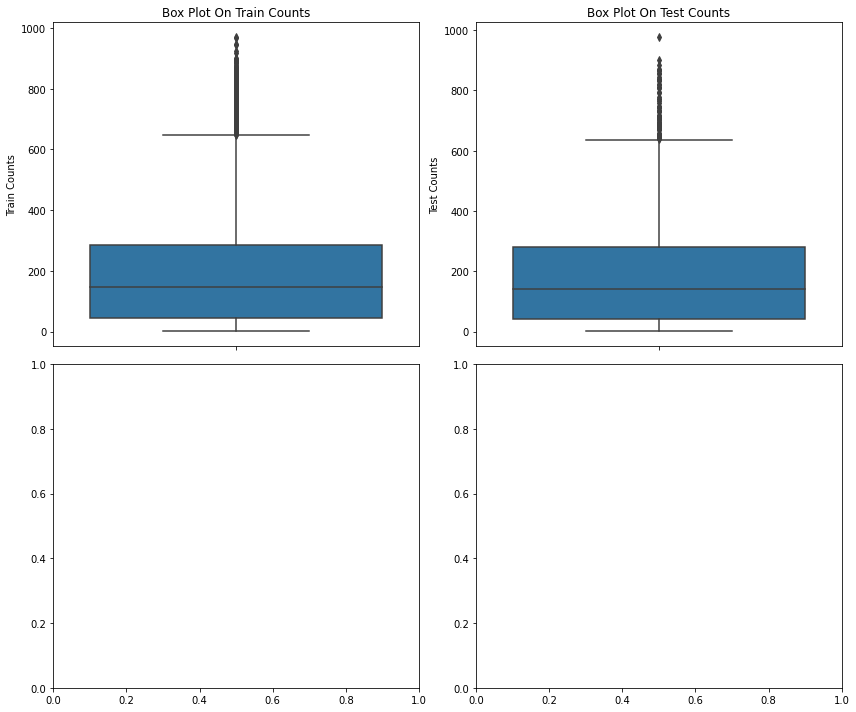

In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# TODO: figure out why nrows must = 2 instead of 1 for this to work.
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(data=bike_train_label.to_frame(),y="count",orient="v",ax=axes[0][0])
sns.boxplot(data=bike_test_label.to_frame(),y="count",orient="v",ax=axes[0][1])

axes[0][0].set(ylabel='Train Counts',title="Box Plot On Train Counts")
axes[0][1].set(ylabel='Test Counts',title="Box Plot On Test Counts")

plt.tight_layout()

## Training Data Resembles Exponential Distribution

Text(24.0, 0.5, 'num times hrly cnt repeated')

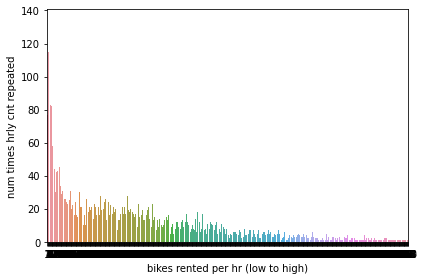

In [15]:
feature_names=['count']
i=0
for name in feature_names:
    i=i+1
    plt.subplot(len(feature_names),1,i)
    sns.countplot(name,data=bike_train_label.to_frame()) 
plt.tight_layout()    
plt.xlabel("bikes rented per hr (low to high)")
plt.ylabel("num times hrly cnt repeated")


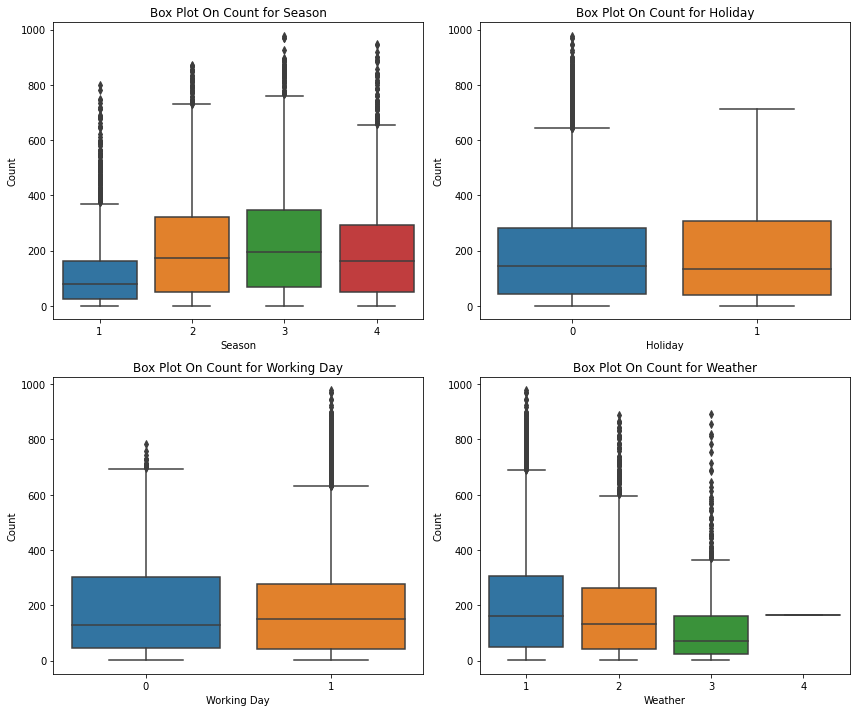

In [16]:
# Display:
#   season - 1 = spring, 2 = summer, 3 = fall, 4 = winter 
#   holiday - 1 = holiday, 0 = otherwise
#   workingday - 1 = not a weekend or a holiday, 0 = otherwise
#   weather - 
#     1: Clear, Few clouds, Partly cloudy, Partly cloudy
#     2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
#     3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
#     4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(data=bike_input,y="count",x="season",orient="v",ax=axes[0][0])
sns.boxplot(data=bike_input,y="count",x="holiday",orient="v",ax=axes[0][1])
sns.boxplot(data=bike_input,y="count",x="workingday",orient="v",ax=axes[1][0])
sns.boxplot(data=bike_input,y="count",x="weather",orient="v",ax=axes[1][1])

axes[0][0].set(xlabel='Season', ylabel='Count',title="Box Plot On Count for Season")
axes[0][1].set(xlabel='Holiday', ylabel='Count',title="Box Plot On Count for Holiday")
axes[1][0].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count for Working Day")
axes[1][1].set(xlabel='Weather', ylabel='Count',title="Box Plot On Count for Weather")

plt.tight_layout()

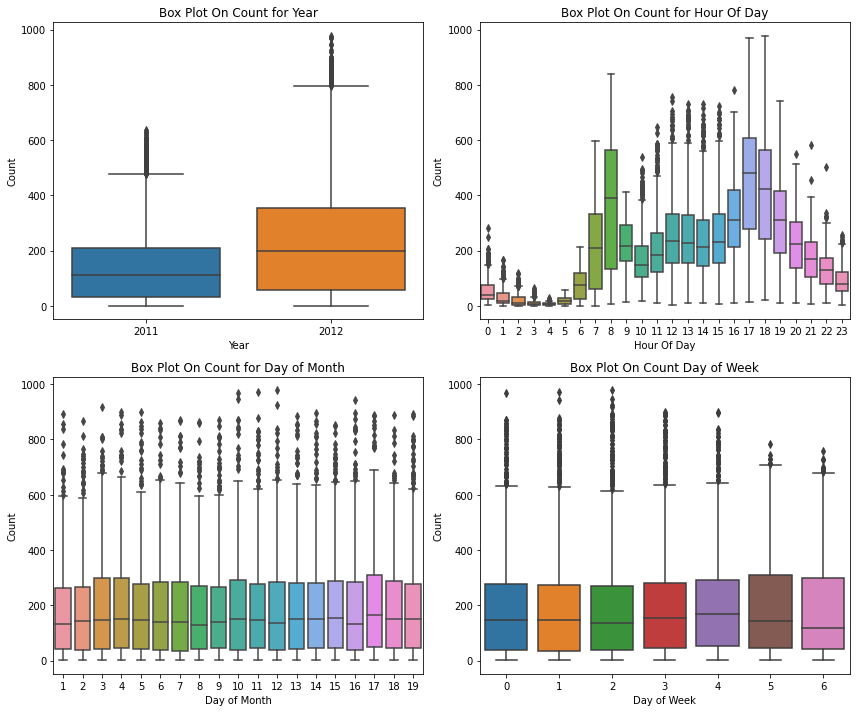

In [17]:
# Display:
#   year - 2011, 2012
#   hour (0-23)
#   day - day of the month (1-31)
#   dow - day-of-the-week (0-Mon, 1-Tue, 2-Wed, 3-Thu, 4-Fri, 5-Sat, 6-Sun)
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(data=bike_input,y="count",x="year",orient="v",ax=axes[0][0])
sns.boxplot(data=bike_input,y="count",x="hour",orient="v",ax=axes[0][1])
sns.boxplot(data=bike_input,y="count",x="day",orient="v",ax=axes[1][0])
sns.boxplot(data=bike_input,y="count",x="dow",orient="v",ax=axes[1][1])

axes[0][0].set(xlabel='Year', ylabel='Count',title="Box Plot On Count for Year")
axes[0][1].set(xlabel='Hour Of Day', ylabel='Count',title="Box Plot On Count for Hour Of Day")
axes[1][0].set(xlabel='Day of Month', ylabel='Count',title="Box Plot On Count for Day of Month")
axes[1][1].set(xlabel='Day of Week', ylabel='Count',title="Box Plot On Count Day of Week")

plt.tight_layout()

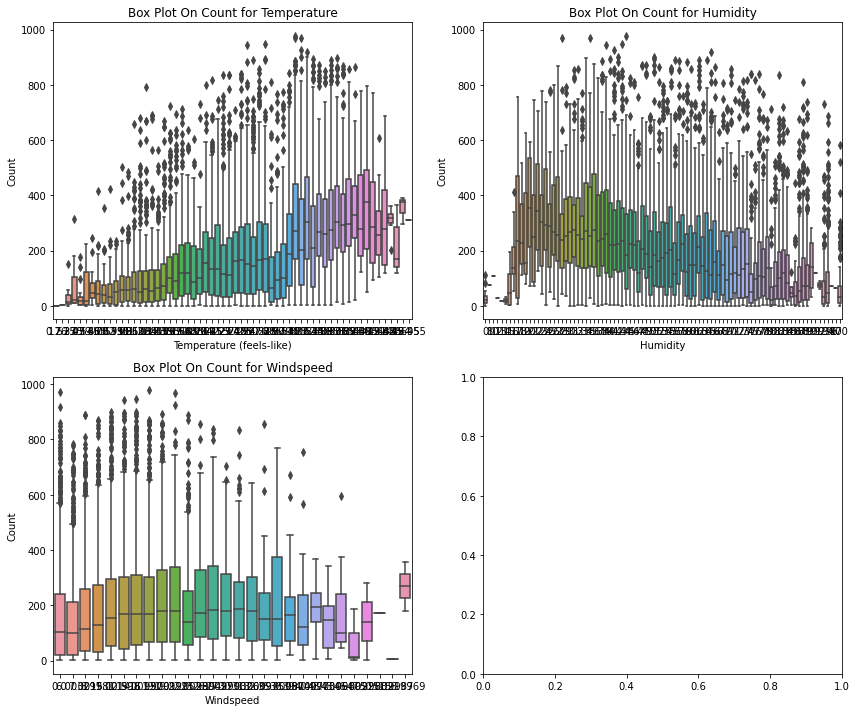

In [18]:
# Display:
#   atemp - "feels like" temperature in Celsius
#   humidity - relative humidity
#   windspeed - wind speed
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(data=bike_input,y="count",x="atemp",orient="v",ax=axes[0][0])
sns.boxplot(data=bike_input,y="count",x="humidity",orient="v",ax=axes[0][1])
sns.boxplot(data=bike_input,y="count",x="windspeed",orient="v",ax=axes[1][0])

axes[0][0].set(xlabel='Temperature (feels-like)', ylabel='Count',title="Box Plot On Count for Temperature")
axes[0][1].set(xlabel='Humidity', ylabel='Count',title="Box Plot On Count for Humidity")
axes[1][0].set(xlabel='Windspeed', ylabel='Count',title="Box Plot On Count for Windspeed")

plt.tight_layout()

In [19]:
# There was a high correlation (i.e. > 97%) between:
# - temperature and "feels-like temperature" (very high 98%)
# - season and month (very high 97%)
# Therefore these features have been removed. See "Load and
# Clean Kaggle Bicycle Dataset" section above.
#
# There still is a high correlation (i.e. > 40%) between:
# - workingday and dow (day-of-week)
# - weather and humidity

bike_train.corr()

,atemp,humidity,windspeed
atemp,1.000000,-0.044105,-0.055735
humidity,-0.044105,1.000000,-0.324552
windspeed,-0.055735,-0.324552,1.000000


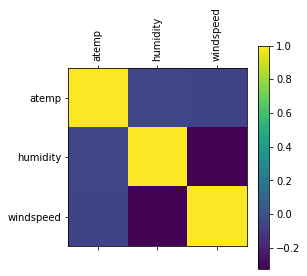

In [20]:
# Matplotlib code to display the correlations.
correlation_matrix = bike_train.corr()
plt.matshow(correlation_matrix)
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation='vertical')
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.colorbar()
plt.show()

## First Pass Training Find Optimum Value for n_estimators

Set the following regression model parameters:
- <b>n_estimators</b>: number of boosting stages to be performed.
- <b>max_depth</b>: limits the number of nodes in the tree.
- <b>min_samples_split</b>: the minimum number of samples required to split an internal node. Depends on feature correlation.
- <b>learning_rate</b>: how much the contribution of each tree will shrink (i.e. weight reduced).
- <b>subsample</b>: with small <b>learning_rate</b> improves model.
- <b>loss</b>: least squares loss function used to optimize residual error.

### Fit the Model and Check Accuracy

In [21]:
from sklearn import datasets, ensemble
from sklearn.metrics import mean_squared_error

params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.1,
          'loss': 'ls'}

gbr_model = ensemble.GradientBoostingRegressor(**params)
gbr_model.fit(bike_train, bike_train_label)

mse = mean_squared_error(bike_test_label, gbr_model.predict(bike_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("Test accuracy: ", gbr_model.score(bike_test,bike_test_label))

The mean squared error (MSE) on test set: 1900.8150
Test accuracy:  0.9398371122303418


## Plot Feature Importance

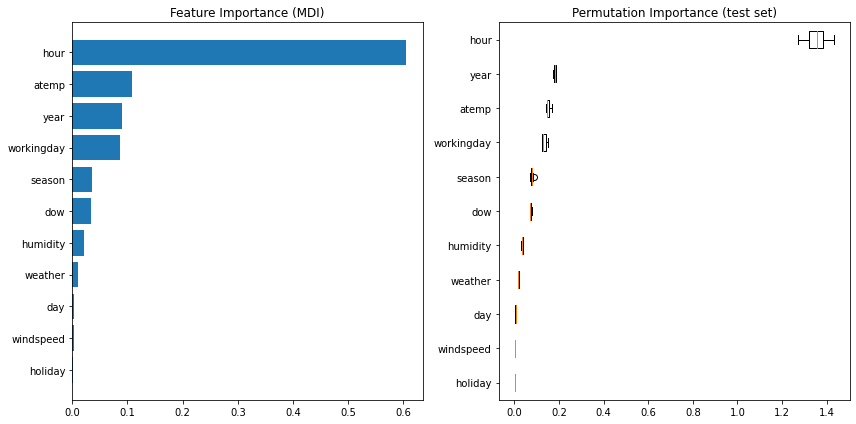

In [22]:
from sklearn.inspection import permutation_importance

feature_importance = gbr_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(bike_train.columns)[sorted_idx])

plt.title('Feature Importance (MDI)')

result = permutation_importance(gbr_model, bike_test, bike_test_label, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(bike_train.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()


## Empirically (trial and error) Find Optimum Values for Hyper-parameters Other Than n_estimators Using GridSearchCV 
- <b>max_depth</b>: limits the number of nodes in the tree. Typically 4 to 8 levels.
- <b>min_samples_split</b>: minimum number of samples required to split an internal node. 2 initially but maybe not optimal for model construction.
- <b>learning_rate</b>: (i.e. shrinkage): try to keep small in order to reduce test error (i.e. <= 0.1). The smaller the value the slower the algorithm learns.
- <b>subsample</b>: typically 0.5 (i.e. 50%), along with a small <b>learning_rate</b> improves the model.
- <b>loss</b>: loss function to optimize. Typically 'ls' (i.e. least squares) for regression model creation.

In [21]:
### TODO: The following hard crashed my dedicated Ubuntu AMD (gaming setup) computer after 2 minutes. 
# Specifically when I changed the parameter loss from ['lad','quantile'] to ['lad','huber','quantile'].
# Specifically when I changed the parameter subsample from [5.0/10.0,9.0/10.0] to [5.0/10.0,7.0/10.0,9.0/10.0].
# Specifically when I changed the parameter learning_rate from [0.5,01] to [0.5,0.1,0.01].
# Specifically when I changed the parameter min_samples_split from range(4,6) to range(3,6).
from sklearn.model_selection import GridSearchCV

parameters=[{
    'max_depth':[i for i in range(6,9)],
    'min_samples_split':[i for i in range(4,6)],
    'learning_rate':[0.5,0.05],
    'subsample':[5.0/10.0,7.0/10.0],
    'loss':['lad','quantile']}]

grid_search=GridSearchCV(estimator=gbr_model, param_grid=parameters, n_jobs=-1)
grid_search.fit(bike_train,bike_train_label)
best_accuracy=grid_search.best_score_
best_parameters=grid_search.best_params_
print(grid_search.get_params())
print (best_accuracy)
print (best_parameters)
print(f'Grid search accuracy: {grid_search.score(bike_test,bike_test_label)}')

{'cv': None, 'error_score': nan, 'estimator__alpha': 0.9, 'estimator__ccp_alpha': 0.0, 'estimator__criterion': 'friedman_mse', 'estimator__init': None, 'estimator__learning_rate': 0.1, 'estimator__loss': 'ls', 'estimator__max_depth': 4, 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_impurity_split': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 5, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__n_estimators': 500, 'estimator__n_iter_no_change': None, 'estimator__presort': 'deprecated', 'estimator__random_state': None, 'estimator__subsample': 1.0, 'estimator__tol': 0.0001, 'estimator__validation_fraction': 0.1, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': GradientBoostingRegressor(max_depth=4, min_samples_split=5, n_estimators=500), 'iid': 'deprecated', 'n_jobs': -1, 'param_grid': [{'max_depth': [6, 7, 8], 'min_samples_split': [4, 5], 'learning_rate': 

## Verify Best Hyper-parameters

In [23]:
params = {'n_estimators': 500,
          'max_depth': 8,
          'min_samples_split': 5,
          'learning_rate': 0.05,
          'subsample': 0.5,
          'loss': 'lad'}

gbr_model_final = ensemble.GradientBoostingRegressor(**params)
gbr_model_final.fit(bike_train, bike_train_label)

mse = mean_squared_error(bike_test_label, gbr_model_final.predict(bike_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("Test accuracy: ", gbr_model_final.score(bike_test,bike_test_label))

The mean squared error (MSE) on test set: 1517.8991
Test accuracy:  0.9519568218299227


## Minimize Test Input 
Remove unimportant features found above.

In [24]:
# Drop unimportant features.
bike_train_min=bike_train.drop(columns=['day','windspeed', 'holiday'])
bike_test_min=bike_test.drop(columns=['day','windspeed', 'holiday'])
gbr_model_final_min = ensemble.GradientBoostingRegressor(**params)
gbr_model_final_min.fit(bike_train_min, bike_train_label)

mse = mean_squared_error(bike_test_label, gbr_model_final_min.predict(bike_test_min))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("Test accuracy: ", gbr_model_final_min.score(bike_test_min,bike_test_label))

The mean squared error (MSE) on test set: 1574.2223
Test accuracy:  0.9501741297213689


## Plot Deviance

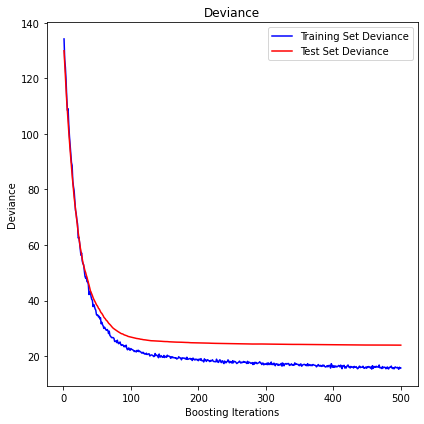

In [25]:
# Visualize the results. Compute the bike test set deviance 
# and then plot it againt the final boosted model.
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(gbr_model_final_min.staged_predict(bike_test_min)):
    test_score[i] = gbr_model_final_min.loss_(bike_test_label, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, gbr_model_final_min.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

## Plot Predictions Against Test Data 

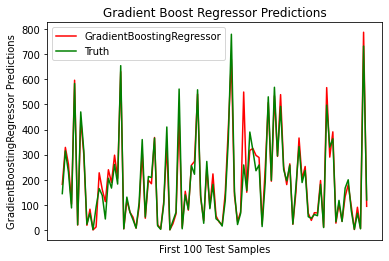

In [64]:
pred1 = gbr_model_final_min.predict(bike_test_min[:100])

plt.figure()
plt.plot(pred1, 'r-', label='GradientBoostingRegressor')
plt.plot((bike_test_label[:100]).to_numpy(), 'g-', label='Truth')
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('GradientBoostingRegressor Predictions')
plt.xlabel('First 100 Test Samples')
plt.legend(loc="best")
plt.title('Gradient Boost Regressor Predictions')
plt.show()

## Use Best Smallest Model to Make Predictions From Final Test Data

42


<Figure size 432x288 with 0 Axes>

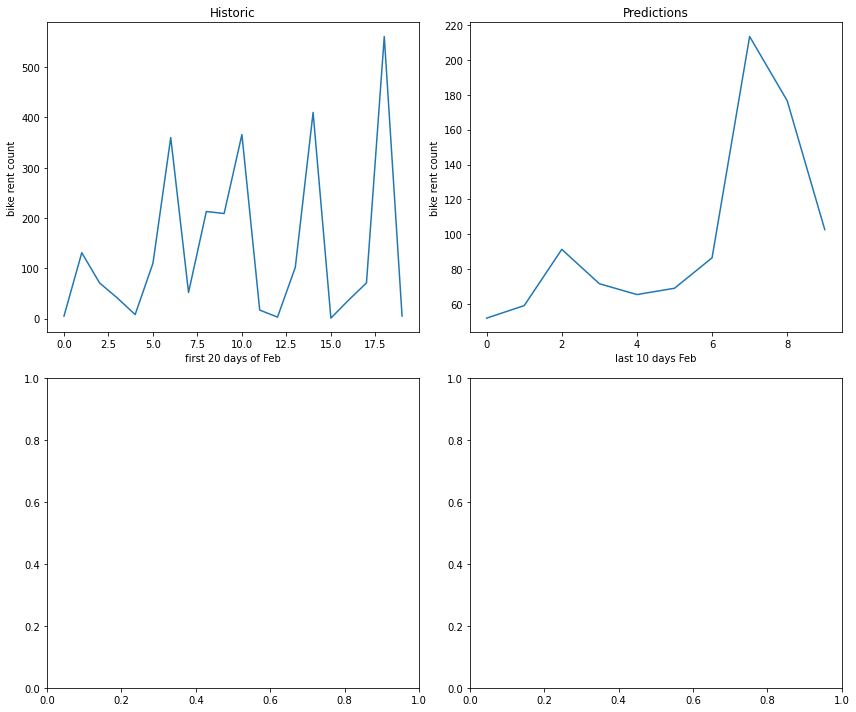

In [66]:
# Drop unimportant features.
bike_final_test_min=bike_final_test.drop(columns=['day','windspeed', 'holiday'])
pred_final = gbr_model_final_min.predict(bike_final_test_min)

print(sum((pred_final)<0))

plt.figure()

# TODO: for some reason nrows has to = 2 instead of 1 to work.
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)

sns.lineplot(data=(bike_test_label[20:40]).to_numpy(),ax=axes[0][0])
sns.lineplot(data=pred_final[10:20],ax=axes[0][1])

axes[0][0].set(xlabel='first 20 days of Feb', ylabel='bike rent count',title="Historic")
axes[0][1].set(xlabel='last 10 days Feb', ylabel='bike rent count',title="Predictions")

plt.tight_layout()
plt.show()

## Create the Kaggle Submission file.

In [122]:
# Read bike demand submission file into a panda dataframe.
bike_submit=pd.read_csv('./bike-sharing-demand-sampleSubmission.csv')

# Overwrite bike demand dataframe count column with predicted counts.
bike_submit['count']=pred_final

# Replace negative counts with 0 so submission will not be rejected by Kaggle.
i=0
for bike in bike_submit['count']:
    if (bike<0):
        bike_submit.loc[i,'count'] = 0
    i+=1

# Overwrite bike demand submission file with bike demand dataframe.
bike_submit.to_csv('./submission.csv', index=False)

In [118]:
bike_submit

,datetime,count
0,2011-01-20 00:00:00,12.013540
1,2011-01-20 01:00:00,5.659169
2,2011-01-20 02:00:00,3.480775
3,2011-01-20 03:00:00,3.272588
4,2011-01-20 04:00:00,1.759703
...,...,...
6488,2012-12-31 19:00:00,217.047167
6489,2012-12-31 20:00:00,132.242113
6490,2012-12-31 21:00:00,100.466626
6491,2012-12-31 22:00:00,78.828491
